In [4]:
# Import Libraries
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('vader_lexicon')
from IPython.display import display
import csv
import geopy
from pathlib import Path  
import sys
from bs4 import BeautifulSoup
import urllib
import json
import ast
import time
import geopandas as gpd

import matplotlib.pyplot as plt


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\amer_\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Authentication
consumerKey = "jLsJDtWU8yD5tZlcmwlzYnGjj"
consumerSecret = "Y236WRUhs5ylGfcZwjmabwPRWwedThHVB8gFVBPC3oTNAbRnCz"
accessToken = "964316780993933313-ZJOdE1MRMA8WyqZoNajtj0EWy4KQVDI"
accessTokenSecret = "qMOuqbyZmKXQTVXGFofwriLZpZn5zAAwGjsw0Wlft7M0a"
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth, wait_on_rate_limit = True)
file_dir = Path.cwd()

In [3]:

# The below function takes a given state, and returns a dataframe with every county and its corresponding square milage
def county_sqFootage(state):
	state = re.sub(' ', '-', state)
	url = urllib.request.urlopen('http://www.usa.com/rank/' +state.lower() + '-state--land-area--county-rank.htm')
	path = url.read()
	# empty list
	data = []
	# for getting the header from
	# the HTML file
	list_header = []
	soup = BeautifulSoup((path),'html.parser')
	header = soup.find_all("table")[1].find("tr")
	for items in header:
		try:
			list_header.append(items.get_text())
		except:
			continue
	# for getting the data
	HTML_data = soup.find_all("table")[1].find_all("tr")[1:]
	for element in HTML_data:
		sub_data = []
		for sub_element in element:
			try:
				sub_data.append(sub_element.get_text())
			except:
				continue
		data.append(sub_data)
	# Storing the data into Pandas
	# DataFrame
	df = pd.DataFrame(data = data, columns = list_header)
	df.drop(df.columns[[0]],axis = 1,inplace = True)
	df.rename(columns = {'County / Population':'County','Land Area ▼':'Area'}, inplace = True)
	# Removing the section of the data for population information and deleting it
	formatdf= df['County'].str.split(',',expand = True)
	formatdf = formatdf[0]
	# recombining the data
	df = df['Area'].str.split(' sq', expand = True)
	df = df.replace({',':''}, regex=True)	
	df = df[0]
	df= pd.concat([df,formatdf],axis=1,join = 'inner')
	df.columns = ['Area','County']
	df['County']=df['County'].str.upper()
	df['Radius'] = df['Area'].astype(float)
	df['Radius'] = df['Radius'].apply(lambda x: (x/3.1415)**.5)
	# Search Radius is what the Twitter API will end up using
	return df	

	# Main code logic copied from Codegeeks https://www.geeksforgeeks.org/convert-html-table-into-csv-file-in-python/

print(county_sqFootage('Texas'))

        Area     County     Radius
0    6183.73   BREWSTER  44.366659
1    4763.84      PECOS  38.941265
2    4570.98   HUDSPETH  38.144869
3    3855.23   PRESIDIO  35.031329
4    3812.79  CULBERSON  34.837976
..       ...        ...        ...
249   251.98     MORRIS   8.956009
250   229.45      RAINS   8.546248
251   195.83       CAMP   7.895344
252   186.46  SOMERVELL   7.704143
253   127.04   ROCKWALL   6.359189

[254 rows x 3 columns]


In [4]:
def create_wordcloud(text,keyword):
    file_path = os.path.join(file_dir, 'Keyword State')
    mask = np.array(Image.open('cloud.png'))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color='white',
    mask = mask,
    max_words=3000,
    stopwords=stopwords,
    repeat=True)
    wc.generate(str(text))
    name = (state) + " on the term " + keyword+ ".png"
    path= os.path.join(file_path,name)
    wc.to_file(path)
    print("Word Cloud Saved Successfully")
    display(Image.open(path))

In [5]:

def getCountyInfo(state):
    
    csv_folder = 'State information'
    file_path = os.path.join(file_dir, csv_folder, (state+'.csv'))
    print((Path.cwd() / csv_folder /(state+'.csv')).exists())    
    if((Path.cwd() / csv_folder /(state+'.csv')).exists()):
        data = pd.read_csv(file_path)
    else:
        print('boop')
        # make a program that uses this dataset https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv
        # to get all the cities in a state
        data = pd.read_csv('https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv',sep='|')
        del data['State short'], data['City'],data['City alias']
        data.columns = data.columns.str.replace('State full', 'State')
        data = data[data.State == state]
        data.drop_duplicates(subset='County', keep='first', inplace=True)
        del data['State']
        coordinates = []
        for county in data['County']:
            print(county)
            locator = geopy.Photon(user_agent="myGeocoder")
            location = locator.geocode(county.lower() + ',' + state + ', United States')
            # Make a new column in my dataframe with the lat and long
            coordinates.append([location.latitude,location.longitude])
        data['Coordinates'] = coordinates
        area = county_sqFootage(state)
        data = pd.merge(data,area, on= 'County', how = 'outer')
        data.rename(columns = {'Area':'Area (sq/mi)','Radius':'Radius (mi)'}, inplace = True)
        data.to_csv(file_path)
    return data

print(getCountyInfo('Texas'))

True
     Unnamed: 0     County                 Coordinates  Area (sq/mi)  \
0             0     TRAVIS   [30.2878569, -97.7561392]        990.20   
1             1    SHERMAN  [36.2452294, -101.8858689]        923.03   
2             2     DALLAS   [32.7762719, -96.7968559]        871.28   
3             3     COLLIN   [33.1609629, -96.6060984]        841.22   
4             4     DENTON   [33.1838787, -97.1413417]        878.43   
..          ...        ...                         ...           ...   
249         249    EL PASO   [31.7754152, -106.464634]       1012.69   
250         250   BREWSTER  [29.8462742, -103.2400734]       6183.73   
251         251   HUDSPETH  [31.5388627, -105.4752945]       4570.98   
252         252   PRESIDIO  [29.9883766, -104.2336552]       3855.23   
253         253  CULBERSON   [31.4622625, -104.482834]       3812.79   

     Radius (mi)  
0      17.753866  
1      17.141127  
2      16.653685  
3      16.363879  
4      16.721878  
..           ...

In [6]:
#Sentiment Analysis
def percentage(part,whole):
    return 100 * float(part)/float(whole)
noOfTweet = 100
state = 'Texas'
countyDF =  (getCountyInfo(state))
keyword = 'Beto'
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []
cityDict = {}
json_folder = 'Keyword State'
file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))
def average(arr):
    return (sum(arr) / len(arr))
# extract the county collumn from the countyDF and convert its values to a list
countyList = countyDF['County'].values.tolist()
usefulTweets = 0
users = []
county_needed = []
# if file_path exists, set the county_needed list equal to all the items from the county list not present in the keys of the json
total_data = []
if((Path.cwd() / json_folder /(((state) + " on the term " + keyword +'.json'))).exists()):
    f = open(file_path, 'r')
    cityDict = json.load(f)
    checked_counties = cityDict.keys()
    # set county_needed equal to the items in county that aren't present in checked_counties
    county_needed = countyList-checked_counties
    print(county_needed)
    for county in cityDict:
        tweet_list = tweet_list + cityDict[county][2]
    print(len(tweet_list))


else:
    county_needed = countyList
for county in county_needed:
    coordinates = (countyDF.loc[countyDF['County'] == county]['Coordinates'])
    coordinates = np.array(coordinates.values.tolist())[0]
    coordinates = ast.literal_eval(coordinates)
    lat = coordinates[0]
    longi = coordinates[1]
    miles = [countyDF.loc[countyDF['County'] == county]['Radius (mi)'].values[0]][0]
    geocode = str(coordinates[0]) + ',' + str(coordinates[1]) + ',' + str(miles) + 'mi'
    backoff_counter = 1
    while True:
        try:
            tweets = tweepy.Cursor(api.search_tweets, q=keyword,geocode = geocode).items(noOfTweet)
            break
        except tweepy.TweepError as e:
            print(e.reason)
            sleep(60*backoff_counter)
            backoff_counter += 1
            continue
    location = county
    tweet_list_county = []
    if location not in cityDict.keys():
        cityDict[location] = [1,[],[]]
    for tweet in tweets:
        # location = tweet.user.location
        
        username = tweet.user.id
        # location = (location.replace(', TX', '')).lower()
        cityDict[location][0]+=1
            
        tweet_list.append(tweet.text)
        analysis = TextBlob(tweet.text)
        score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
        neg = score['neg']
        neu = score['neu']
        pos = score['pos']
        comp = score['compound']
        if (username not in users) and (tweet not in tweet_list):
            tweet_list_county.append(tweet.text)
            usefulTweets+=1
            polarity += analysis.sentiment.polarity
            cityDict[location][1].append(comp)
            if neg > pos:
                negative_list.append(tweet.text)
                negative += 1
            elif pos > neg:
                positive_list.append(tweet.text)
                positive += 1
            
            elif pos == neg:
                neutral_list.append(tweet.text)
                neutral += 1
            users.append(username)
            # Keep track of unique tweets per city
        # cityDict[location][2].append(tweet_list_county)
        # save the cityDict to a json file at directory file_path
        with open(file_path, 'w') as fp:
            json.dump(cityDict, fp)
        
    print("For the county of " + str(county) + ", there were " + str(cityDict[location][0]) + " unique tweets")
for city in countyList:
    cityDict[city].pop(2)
    if(len(cityDict[city][1]) > 0):
        cityDict[city][1] = sum(cityDict[city][1])/len(cityDict[city][1])
    else:
        print(city)
        cityDict.pop(city)
    
    # delete the second index of cityDIct
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')
# fully expand all lower levels of the list to the first level
tweet_list = list(set(tweet_list))
print(len(tweet_list))
with open(file_path, 'w') as fp:
            json.dump(cityDict, fp)
# make a new dictionary identical to countyDict but without the second index



True
For the county of TRAVIS, there were 101 unique tweets
For the county of SHERMAN, there were 1 unique tweets
For the county of DALLAS, there were 101 unique tweets
For the county of COLLIN, there were 40 unique tweets
For the county of DENTON, there were 27 unique tweets
For the county of GRAYSON, there were 5 unique tweets
For the county of ROCKWALL, there were 6 unique tweets
For the county of ELLIS, there were 2 unique tweets
For the county of NAVARRO, there were 2 unique tweets
For the county of VAN ZANDT, there were 2 unique tweets
For the county of KAUFMAN, there were 3 unique tweets
For the county of HENDERSON, there were 1 unique tweets
For the county of HUNT, there were 3 unique tweets
For the county of WOOD, there were 1 unique tweets
For the county of LAMAR, there were 5 unique tweets
For the county of RED RIVER, there were 2 unique tweets
For the county of FANNIN, there were 2 unique tweets
For the county of DELTA, there were 1 unique tweets
For the county of HOPKINS, 

Rate limit reached. Sleeping for: 845


For the county of MONTGOMERY, there were 38 unique tweets
For the county of WALKER, there were 28 unique tweets
For the county of LIBERTY, there were 9 unique tweets
For the county of SAN JACINTO, there were 2 unique tweets
For the county of GRIMES, there were 27 unique tweets
For the county of HARDIN, there were 1 unique tweets
For the county of MATAGORDA, there were 1 unique tweets
For the county of COLORADO, there were 1 unique tweets
For the county of AUSTIN, there were 101 unique tweets
For the county of WHARTON, there were 1 unique tweets
For the county of BRAZORIA, there were 3 unique tweets
For the county of WALLER, there were 9 unique tweets
For the county of WASHINGTON, there were 1 unique tweets
For the county of GALVESTON, there were 12 unique tweets
For the county of CHAMBERS, there were 1 unique tweets
For the county of ORANGE, there were 6 unique tweets
For the county of JEFFERSON, there were 2 unique tweets
For the county of BRAZOS, there were 32 unique tweets
For the c

Rate limit reached. Sleeping for: 853


For the county of STONEWALL, there were 1 unique tweets
For the county of NOLAN, there were 1 unique tweets
For the county of TAYLOR, there were 10 unique tweets
For the county of HOWARD, there were 1 unique tweets
For the county of MITCHELL, there were 1 unique tweets
For the county of SCURRY, there were 1 unique tweets
For the county of KENT, there were 1 unique tweets
For the county of FISHER, there were 1 unique tweets
For the county of MIDLAND, there were 17 unique tweets
For the county of MARTIN, there were 1 unique tweets
For the county of ANDREWS, there were 1 unique tweets
For the county of REEVES, there were 1 unique tweets
For the county of WARD, there were 1 unique tweets
For the county of PECOS, there were 1 unique tweets
For the county of CRANE, there were 1 unique tweets
For the county of JEFF DAVIS, there were 1 unique tweets
For the county of BORDEN, there were 1 unique tweets
For the county of GLASSCOCK, there were 1 unique tweets
For the county of ECTOR, there were 9

In [7]:


positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')
print(cityDict)
print('---')
# remove duplicates from tweet_list
# Function got too chambers before hitting rate limit

{'TRAVIS': [101, 0.11724204545454545], 'DALLAS': [101, 0.15443793103448278], 'COLLIN': [40, 0.24310357142857145], 'DENTON': [27, 0.11686666666666666], 'GRAYSON': [5, 0.3125], 'ROCKWALL': [6, 0.0], 'ELLIS': [2, 0.4588], 'NAVARRO': [2, 0.4215], 'VAN ZANDT': [2, 0.5859], 'KAUFMAN': [3, 0.6688], 'HUNT': [3, 0.47015], 'LAMAR': [5, 0.0], 'RED RIVER': [2, 0.0], 'BOWIE': [3, 0.7384], 'GREGG': [2, 0.1531], 'HARRISON': [3, -0.891], 'SMITH': [11, 0.12437500000000001], 'CHEROKEE': [2, 0.0], 'NACOGDOCHES': [10, 0.27624285714285707], 'HOUSTON': [101, 0.10478000000000003], 'POLK': [4, -0.0086], 'TARRANT': [64, 0.07725454545454548], 'PARKER': [3, 0.29295], 'JOHNSON': [2, 0.2732], 'HILL': [5, -0.25085], 'COOKE': [2, 0.1531], 'WICHITA': [11, 0.3087285714285714], 'BELL': [5, 0.13579999999999998], 'CORYELL': [5, -0.17069999999999996], 'MCLENNAN': [5, 0.2079], 'WILLIAMSON': [14, 0.30428571428571427], 'LLANO': [2, 0.0], 'CONCHO': [16, 0.04033076923076923], 'TOM GREEN': [22, 0.21145], 'HARRIS': [101, 0.29647

In [8]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print('total number: ',len(tweet_list))
print('positive number: ',len(positive_list))
print('negative number: ', len(negative_list))
print('neutral number: ',len(neutral_list))

total number:  1042
positive number:  314
negative number:  119
neutral number:  391


In [9]:
#Cleaning Text (RT, Punctuation etc)

#Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]

#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(tweet_list.shape[0])

,0,text
0,O’Rourke’s decision to challenge Gov. Greg Abb...,o rourke s decision to challenge gov greg abb...
1,@joncoopertweets @BetoORourke He'll lose. \n\n...,he ll lose texas will elect the corpse ...
2,@4a_of Look at this. 💙 https://t.co/zSIuozSPoE,of look at this
3,"@HaikuStock ""Democrats in disarray"" even thoug...",democrats in disarray even though dems hav...
4,#ImWithHim #Beto https://t.co/B9yTGyxpGS,imwithhim beto
...,...,...
1037,https://t.co/mdwefZEsGB,
1038,"Voters' Rights laws, the John Lewis Voting Rig...",voters rights laws the john lewis voting rig...
1039,"@DaddeLion Then don't vote for Beto, because t...",then don t vote for beto because that s exa...
1040,I'll keep my AR-15.\n\nYou can keep Beto.,i ll keep my ar 15 you can keep beto


In [10]:
#Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = "positive"
    else:
        tw_list.loc[index, 'sentiment'] = "neutral"
        tw_list.loc[index, 'neg'] = neg
        tw_list.loc[index, 'neu'] = neu
        tw_list.loc[index, 'pos'] = pos
        tw_list.loc[index, 'compound'] = comp
tw_list.head(10)
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

In [11]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,"sentiment")

,Total,Percentage
neutral,455,43.67
positive,420,40.31
negative,167,16.03


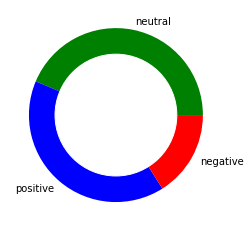

In [12]:
# create data for Pie Chart
pc = count_values_in_column(tw_list,'sentiment')
names= pc.index
size=pc['Percentage']
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Word Cloud Saved Successfully


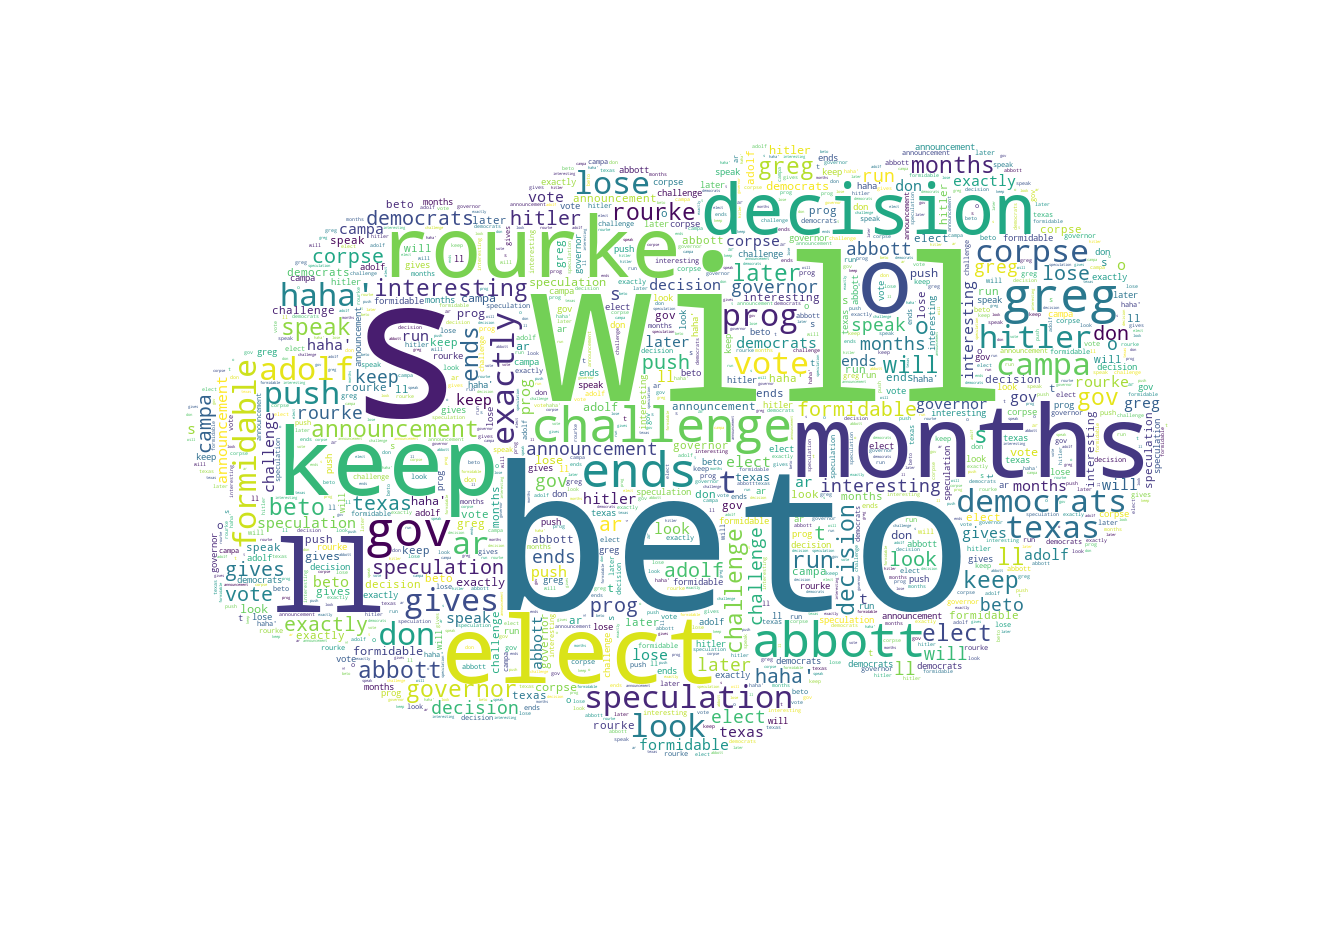

In [13]:
cloud = create_wordcloud(tw_list['text'].values,keyword)
# save the wordcloud image


In [17]:
from matplotlib import colors
import matplotlib.cm as cm

def mapStateData(state,keyword):
    json_folder = 'Keyword State'
    # keyword = 'Transgender'
    file_dir = Path.cwd()
    file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))
    fig, (ax1,ax2) = plt.subplots(ncols=2)
    shape_dir = os.path.join(file_dir, 'Shapes', 'United States','USA_Counties.shx')
    name = ((state) + " on the term " + keyword +'.json')
    unitedStates = gpd.read_file(shape_dir)
    unitedStates = unitedStates[['STATE_NAME','NAME','geometry']].copy()
    unitedStates = unitedStates[unitedStates.STATE_NAME == state]
    unitedStates['NAME'] = unitedStates['NAME'].str.upper()
    unitedStates.rename(columns={'NAME':'County'}, inplace=True)
    # Okay turn the dictionary into a dataframe where one column is filled with keys, and the other column is the first value in the dictionary
    f = open(file_path, 'r')
    state_dict = json.load(f)
    stateDF = pd.DataFrame.from_dict(state_dict, orient='index')
    stateDF.reset_index(inplace=True)
    stateDF.rename(columns={'index': 'County', 0 :'# of Tweets',1:'score'}, inplace=True)

    unitedStates = pd.merge(unitedStates,stateDF, on= 'County', how = 'outer')
    cm1 = colors.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])

    # Make a normalizer that will map the time values from
    # [start_time,end_time+1] -> [0,1].

    # Turn these into an object that can be used to map time values to colors and
    # can be passed to plt.colorbar().
    norm = colors.TwoSlopeNorm(vmin=-.6, vcenter=0, vmax=.6)
    fig.set_size_inches(9, 3)
    title = (state + " on the term \"" + keyword +"\"")
    fig.suptitle(title, fontsize=15)
    fig.tight_layout()
    ax1 = unitedStates.plot(ax = ax1,cmap = cm1, norm= norm,edgecolor='black',column = 'score',legend = True, legend_kwds={'label':'Sentiment Score','orientation':'vertical'})
    title1 = ('Sentiment')
    ax1.set_title(title1)
    ax1.set_axis_off()   
    ax2 = unitedStates.plot(ax=ax2,cmap = 'OrRd',edgecolor='black',column = '# of Tweets',legend = True, legend_kwds={'label':'# of Tweets','orientation':'vertical'})
    title2 = ('# Of Pulled Tweets')
    ax2.set_title(title2)
    ax2.set_axis_off()
    save_dir=os.path.join(file_dir, 'Maps', state)

    if(os.path.isdir(save_dir)):
        save_name = os.path.join(file_dir, 'Maps', state,keyword +'.png')
    else:
        # make a directory in the maps folder with the name of the given state
        os.mkdir(save_dir)
        save_name = os.path.join(file_dir, 'Maps', state,keyword +'.png')
    # save the figure to the maps folder inside the folder corresponding to the state

    plt.savefig(save_name,dpi=300,facecolor='white', transparent=False)



In [ ]:
mapStateData()

In [19]:
def refreshMaps():
    folders = (os.path.join(file_dir,'Maps'))
    subfolders =os.listdir(folders)
    print(subfolders)
    for state in subfolders:
        print(state)
        path = os.path.join(file_dir, 'Maps', state)
        files = os.listdir(path)
        for f in files:
            f = f[:-4]
            mapStateData(state,f)